In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
import torch
from torch import Tensor

from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform

In [107]:
class XYY_YToHH_8b(BaseTransform):
    def __init__(self):
        self.feynman = gnn.Transform(
            gnn.MotherNode(1, id=9, pairs=[1,2], connects=0),
            gnn.MotherNode(1, id=10, pairs=[3,4], connects=0),
            gnn.MotherNode(1, id=11, pairs=[5,6], connects=0),
            gnn.MotherNode(1, id=12, pairs=[7,8], connects=0),

            # gnn.MotherNode(2, id=13, pairs=[9,10], connects=1),
            # gnn.MotherNode(2, id=14, pairs=[11,12], connects=1),

            # gnn.MotherNode(3, id=15, pairs=[13,14], connects=2),
        )
    
    def __call__(self, data : Data) -> Data:
        return self.feynman(data)

In [108]:
from torch_geometric.loader import DataLoader

def load_dataset(fn='data/MX_1200_MY_500-training', template=None):
    dataset = gnn.Dataset(fn,transform=template.transform)
    training, testing = gnn.train_test_split(dataset[:3000], 0.33)
    training, validation = gnn.train_test_split(training, 0.5)

    trainloader = DataLoader(training, batch_size=50, shuffle=True, num_workers=8)
    validloader = DataLoader(validation, batch_size=50, shuffle=True, num_workers=8)
    testloader = DataLoader(testing, batch_size=50, shuffle=True, num_workers=8)

    return trainloader, validloader, testloader

template = gnn.Dataset('data/template',make_template=True, transform=XYY_YToHH_8b())
trainloader, validloader, testloader = load_dataset(template=template)

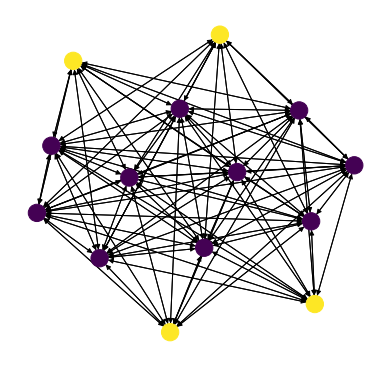

In [144]:
from torch_geometric.utils import to_networkx
import networkx as nx

data = next( data for data in trainloader.dataset if data.y.sum() == 8 )
nx.draw(to_networkx(data,remove_self_loops=True), node_color=data.node_type)

In [145]:
data.node_type, data.node_id

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]),
 tensor([ 5,  3,  2,  0,  1,  6,  7,  8,  4,  0,  9, 10, 11, 12]))

In [245]:
adj = torch.sparse_coo_tensor(data.edge_index, data.edge_y).to_dense().float()
adj = adj[:-4,:-4]

In [246]:
higgs_idx = torch.where(data.node_type == 1)[0]

In [272]:
#                      [ 5,  3,  2,  0,  1,  6,  7,  8,  4,  0,  9, 10, 11, 12]
h1_pair = torch.tensor([ 0,  0,  1,  0,  1,  0,  0,  0,  0,  0])
h2_pair = torch.tensor([ 0,  1,  0,  0,  0,  0,  0,  0,  1,  0])
h3_pair = torch.tensor([ 1,  0,  0,  0,  0,  1,  0,  0,  0,  0])
h4_pair = torch.tensor([ 0,  0,  0,  0,  0,  0,  1,  1,  0,  0])

h_pairs = torch.stack([h1_pair,h2_pair,h3_pair,h4_pair]).float()

In [273]:
h_pairs.T @ h_pairs

tensor([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [281]:
h_pairs = torch.rand(4, 10)

In [282]:
h_perm = torch.eye(4)[torch.randperm(4)]
n_perm = torch.eye(data.num_nodes-4)[torch.randperm(data.num_nodes-4)]
h_pairs_perm = h_perm @ h_pairs @ n_perm.T
adj_perm = n_perm @ adj @ n_perm.T

h2 = h_pairs.T @ h_pairs
h2_perm = h_pairs_perm.T @ h_pairs_perm

y = h2 @ adj @ h2.T
y_perm = h2_perm @ adj_perm @ h2_perm.T 

y, y_perm, ((y - y_perm)**2).sum()

(tensor([[15.4711, 10.8135, 17.5343, 14.3578, 12.4221,  5.3870, 11.7604, 14.1156,
          12.4249, 13.7575],
         [10.8135,  7.5152, 12.2640, 10.0663,  8.6695,  3.7699,  8.1927,  9.8536,
           8.6888,  9.5721],
         [17.5343, 12.2640, 19.7879, 16.2118, 14.1130,  6.0134, 13.2883, 15.9509,
          14.1047, 15.6170],
         [14.3578, 10.0663, 16.2118, 13.2626, 11.5547,  4.9344, 10.9086, 13.0681,
          11.5489, 12.7979],
         [12.4221,  8.6695, 14.1130, 11.5547,  9.9545,  4.3598,  9.4568, 11.3412,
           9.9740, 11.0155],
         [ 5.3870,  3.7699,  6.0134,  4.9344,  4.3598,  1.7747,  4.0501,  4.8582,
           4.3544,  4.8073],
         [11.7604,  8.1927, 13.2883, 10.9086,  9.4568,  4.0501,  8.8906, 10.7056,
           9.4529, 10.4549],
         [14.1156,  9.8536, 15.9509, 13.0681, 11.3412,  4.8582, 10.7056, 12.8280,
          11.3643, 12.5235],
         [12.4249,  8.6888, 14.1047, 11.5489,  9.9740,  4.3544,  9.4529, 11.3643,
           9.9624, 11.0669],
 

In [267]:
(y[0] * y[1:]).sum(dim=-1)

tensor([32.7200, 22.8839, 29.5378])

In [254]:
from pytorch_lightning import LightningModule, Trainer
from torch.nn.functional import nll_loss, softmax
from torchmetrics.functional import accuracy, auroc

class Model(LightningModule):
    def __init__(self, n_nodes=32):
        super().__init__()
        self.conv = gnn.layers.GCNConvMSG(n_in_node=5, n_in_edge=4, n_out=n_nodes)
        self.relu = gnn.layers.GCNRelu()
        self.edge0_linear = gnn.layers.EdgeLinear(3*n_nodes, 2)
        self.edge1_linear = gnn.layers.EdgeLinear(3*n_nodes, 2)
        self.log_softmax = gnn.layers.GCNLogSoftmax()
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_type = data.get('edge_type', torch.zeros_like(edge_attr[:,0]))

        x, edge_attr = self.conv(x, edge_index, edge_attr)
        x, edge_attr = self.relu(x, edge_index, edge_attr)

        x, edge0_attr = self.edge0_linear(x, edge_index, edge_attr)
        x, edge1_attr = self.edge1_linear(x, edge_index, edge_attr)

        edge_type = torch.repeat_interleave(edge_type[:,None],2, dim=-1).long()
        edge_attr = torch.where(edge_type == 0, edge0_attr, edge1_attr)
        
        x, edge_attr = self.log_softmax(x, edge_index, edge_attr)
        return edge_attr

    def step(self, batch, batch_idx):
        edge_o = self(batch)
        loss = nll_loss(edge_o, batch.edge_y)
        edge_auroc = auroc(torch.exp(edge_o[:,1]), batch.edge_y)
        self.log("auroc",edge_auroc)

        return loss

    def predict(self, data):
        edge_o = self(data)
        return torch.exp(edge_o[:,1])

    def training_step(self, batch, batch_idx): return self.step(batch, batch_idx)
    def test_step(self, batch, batch_idx): return self.step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer



In [45]:
model = Model()
trainer = Trainer(max_epochs=20, gpus=1)
trainer.fit(model, trainloader, validloader)
trainer.test(model, testloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | conv         | GCNConvMSG    | 480   
1 | relu         | GCNRelu       | 0     
2 | edge0_linear | EdgeLinear    | 194   
3 | edge1_linear | EdgeLinear    | 194   
4 | log_softmax  | GCNLogSoftmax | 0     
-----------------------------------------------
868       Trainable params
0         Non-trainable params
868       Total params
0.003     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 21/21 [00:01<00:00, 10.93it/s, loss=0.2, v_num=30]  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing:  95%|█████████▌| 19/20 [00:01<00:00, 22.09it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'auroc': 0.8196516036987305}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:01<00:00, 13.36it/s]


[{'auroc': 0.8196516036987305}]

In [47]:
virt_template = gnn.Dataset('data/template',make_template=True, transform=XYY_YToHH_8b())
virt_trainloader, virt_validloader, virt_testloader = load_dataset(template=virt_template)

In [48]:
virt_model = Model()
trainer = Trainer(max_epochs=20, gpus=1)
trainer.fit(virt_model, trainloader, validloader)
trainer.test(virt_model, testloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | conv         | GCNConvMSG    | 480   
1 | relu         | GCNRelu       | 0     
2 | edge0_linear | EdgeLinear    | 194   
3 | edge1_linear | EdgeLinear    | 194   
4 | log_softmax  | GCNLogSoftmax | 0     
-----------------------------------------------
868       Trainable params
0         Non-trainable params
868       Total params
0.003     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 21/21 [00:01<00:00, 10.80it/s, loss=0.2, v_num=31]  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 20/20 [00:01<00:00, 18.78it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'auroc': 0.8158553838729858}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


[{'auroc': 0.8158553838729858}]

In [49]:
class SelectEdges:
    def __init__(self, score='edge_y', cutoff=0.5):
        self.score=score
        self.cutoff=cutoff
    def __call__(self, data : Data) -> Data:
        if hasattr(self.score, 'predict'):
            score = self.score.predict(data)
        else:
            score = data[self.score]
        data.edge_index = data.edge_index[:, score > self.cutoff ]
        return data
        # return score

In [50]:
import networkx as nx
from torch_geometric.utils import to_networkx

def draw_graph(graph, score='edge_y', cutoff=0.5, figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax 
    plt.sca(ax)

    select_edges = SelectEdges(score=score, cutoff=cutoff)
    graph = select_edges(graph)

    colorMap = {0:'tab:blue',1:'tab:red'}
    node_type = graph.get('node_type', torch.zeros_like(graph.y)).numpy()
    node_color = list(map(colorMap.get, node_type))
    node_label = dict(list(enumerate(graph.node_id.numpy())))

    nx_graph = to_networkx(graph, remove_self_loops=True)
    nx.draw_shell(nx_graph, node_color=node_color, labels=node_label, with_labels=True)

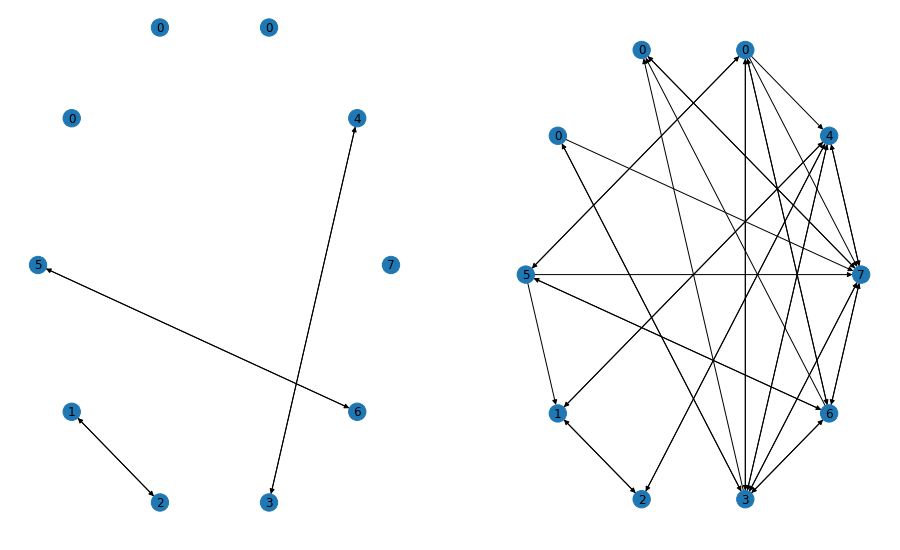

In [51]:
fig,axs = plt.subplots(ncols=2, figsize=(16,10))
draw_graph(trainloader.dataset[0], figax=(fig,axs[0]))
draw_graph(trainloader.dataset[0], score=model, cutoff=0.05, figax=(fig,axs[1]))


In [52]:
class PredictEdges:
    def __init__(self, score='edge_y', cutoff=0.5):
        self.score=score
        self.cutoff=cutoff
    def __call__(self, data : Data) -> Data:
        if hasattr(self.score, 'predict'):
            score = self.score.predict(data)
        else:
            score = data[self.score]

        

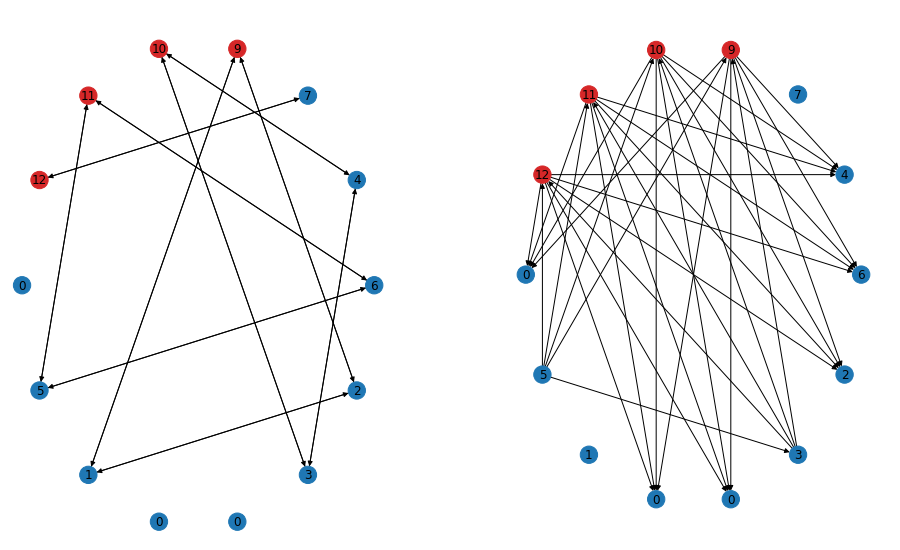

In [55]:
fig,axs = plt.subplots(ncols=2, figsize=(16,10))
draw_graph(virt_trainloader.dataset[0], figax=(fig,axs[0]))
draw_graph(virt_trainloader.dataset[0], score=virt_model, cutoff=0.2, figax=(fig,axs[1]))


In [56]:
graph = virt_testloader.dataset[0]
edge_index = graph.edge_index
score = virt_model.predict(graph)

In [57]:
def mask_edges(edges, mask):
    if edges.shape == mask.shape: return edges[mask]
    nmasks = mask.shape[0]
    return torch.repeat_interleave(edges[None], nmasks, dim=0)[mask].reshape(nmasks,-1)

In [95]:
def find_best_path(graph, origin, jets_to_pair=None):
    if jets_to_pair is None:
        jets_to_pair = (graph.edge_type == 0) & (graph.edge_index[0] != graph.edge_index[1])
    temp_array = 1*jets_to_pair[jets_to_pair,None]

    paths = torch.cat([torch.full_like(temp_array,origin), graph.edge_index[:,jets_to_pair].T, torch.full_like(temp_array,origin)],axis=-1)
    masks = (
        ((paths[:,0,None] == graph.edge_index[0]) & 
        (paths[:,1,None] == graph.edge_index[1])) 
        |
        ((paths[:,1,None] == graph.edge_index[0]) & 
        (paths[:,2,None] == graph.edge_index[1])) 
        |
        ((paths[:,2,None] == graph.edge_index[0]) & 
        (paths[:,3,None] == graph.edge_index[1])) 
    )
    path_score = mask_edges(score,masks).sum(dim=-1)
    best_path_idx = path_score.argmax(dim=-1)
    best_path = paths[best_path_idx]
    remaining_jets = (graph.edge_index[0] == best_path[1]) | (graph.edge_index[0] == best_path[2]) | (graph.edge_index[1] == best_path[1]) | (graph.edge_index[1] == best_path[2])
    jets_to_pair = jets_to_pair & ~remaining_jets

    return (best_path,path_score[best_path_idx]), jets_to_pair

In [96]:
jets_to_pair = None
for node in torch.where(graph.node_type == 1)[0]:
    bp, jets_to_pair = find_best_path(graph, node, jets_to_pair=None)
    print(bp)

(tensor([8, 7, 2, 8]), tensor(1.0719, grad_fn=<SelectBackward>))
(tensor([9, 7, 2, 9]), tensor(1.0719, grad_fn=<SelectBackward>))
(tensor([10,  7,  2, 10]), tensor(1.0719, grad_fn=<SelectBackward>))
(tensor([11,  7,  2, 11]), tensor(1.0719, grad_fn=<SelectBackward>))


In [97]:
score

tensor([0.0134, 0.0008, 0.0110, 0.0226, 0.0611, 0.0153, 0.0093, 0.0365, 0.0013,
        0.0294, 0.0760, 0.0133, 0.0081, 0.0568, 0.0117, 0.0219, 0.0214, 0.1428,
        0.1825, 0.0335, 0.0412, 0.1208, 0.0402, 0.1239, 0.0400, 0.0238, 0.0285,
        0.0734, 0.0891, 0.0629, 0.0051, 0.0236, 0.1174, 0.0097, 0.0352, 0.0885,
        0.0879, 0.0415, 0.0163, 0.0460, 0.0230, 0.0829, 0.1279, 0.0693, 0.0485,
        0.1034, 0.0122, 0.0317, 0.0140, 0.0210, 0.0548, 0.0048, 0.0195, 0.0092,
        0.0069, 0.0312, 0.0302, 0.0169, 0.0666, 0.0171, 0.0315, 0.0158, 0.0166,
        0.1741, 0.0312, 0.0516, 0.4680, 0.2284, 0.1182, 0.1848, 0.0128, 0.1218,
        0.0835, 0.0583, 0.2128, 0.0343, 0.1261, 0.3085, 0.4765, 0.5372, 0.0312,
        0.0516, 0.4680, 0.2284, 0.1182, 0.1848, 0.0128, 0.1218, 0.0835, 0.0583,
        0.2128, 0.0343, 0.1261, 0.3085, 0.4765, 0.5372, 0.0312, 0.0516, 0.4680,
        0.2284, 0.1182, 0.1848, 0.0128, 0.1218, 0.0835, 0.0583, 0.2128, 0.0343,
        0.1261, 0.3085, 0.4765, 0.5372, 

In [76]:
paths, masks = find_best_path(graph, 10, jets_to_pair=None)

In [90]:
path_scores = mask_edges(score, masks).sum(axis=-1)

In [92]:
path_scores.max()

tensor(1.0719, grad_fn=<MaxBackward1>)